In [4]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
Feature engineering is the pipeline aiming at improve the following machine learning modeling by
constructing or selecting features that are more important or related to the TARGET value. Combined
with the DEA analysis part, it will provide suggestions for the features chosen in the following
modeling part. In this work, we tried to create some new features based on the most significant or
finance-related features. The methods we tried here are polynomial methods and prior knowledge
based methods.

* Polynomial methods
* Prior knowledge based methods

## Data import

In [5]:
app_train = pd.read_csv("home-credit-default-risk/application_train.csv")
app_test = pd.read_csv("home-credit-default-risk/application_test.csv")
pre_app = pd.read_csv("home-credit-default-risk/previous_application.csv")


In [ ]:
# check the basic information about the dataframes
print(app_train.shape)
print(app_test.shape)
app_train.head()
pre_app.head()


## Polynomial Methods
We created polynomial features with EXT_SOURCE variable and DAYS_BIRTH variable and applied
a degree of 3 to see the results. These features are previously identified as most correlated with
the target values. The new features were named using get_feature_names.

In [6]:
# Make a new dataframe for polynomial features construction
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                           'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1',
                               'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# make preparation for the imputation of missing value based on sklearn.impute
# Median is used for imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Missisng Values imputation
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

# Create the polynomial object with specified degree
# Degree = 3 here
poly_transformer = PolynomialFeatures(degree=3)


In [7]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


Polynomial Features shape:  (307511, 35)


In [8]:
poly_transformer.get_feature_names(
    input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


Text(0.5, 1.0, 'Correlation Heatmap')

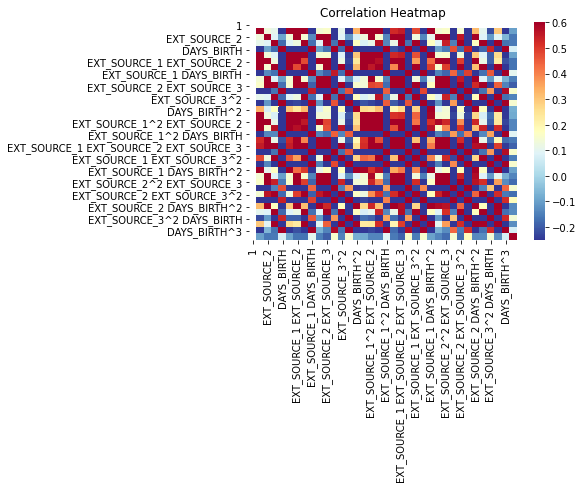

In [9]:
# Check the correlation heatmaps to test the correlated relationships
# of the features and the TARGET value
#poly_corrs.index
ht_poly = poly_features.corr()
sns.heatmap(ht_poly, cmap=plt.cm.RdYlBu_r,
            vmin=-0.25, annot=False, vmax=0.6)
plt.title('Correlation Heatmap')

#plt.bar(poly_corrs.index, poly_corrs)
#plt.xticks(rotation = 90)



## Prior knowledge based methods
Referring to Aguiar’s work, we apply some knowledge in the field of finance to determine whether
a customer will default on a loan using some characteristics.

In [10]:
# Prepare the data for prior knowledge based methods 
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# Constructed the four new features based on existed features
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / \
    app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / \
    app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / \
    app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / \
    app_train_domain['DAYS_BIRTH']


In [11]:
# Make the similar calcualtion for test data set
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / \
    app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / \
    app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / \
    app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / \
    app_test_domain['DAYS_BIRTH']


<AxesSubplot:xlabel='CREDIT_INCOME_PERCENT', ylabel='Density'>

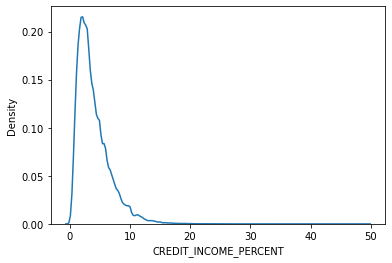

In [12]:
# Simple test for kdeplot
sns.kdeplot(
    app_train_domain.loc[app_train_domain['TARGET'] == 0, 'CREDIT_INCOME_PERCENT'], label='target == 0')


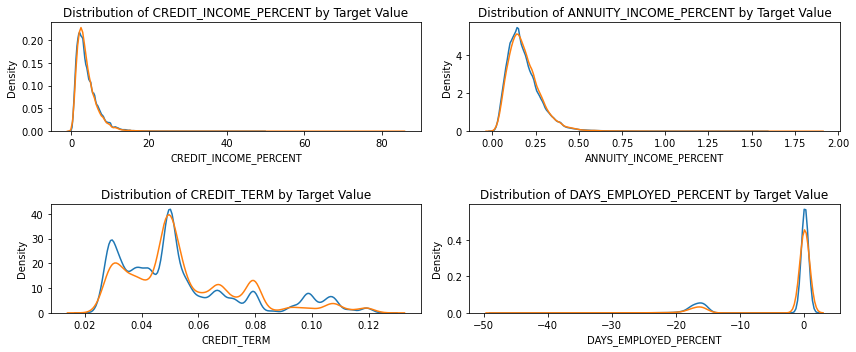

In [46]:
# Overall KDE plots for all four features
plt.figure(figsize=(12, 5))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(2, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(
        app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(
        app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)


## Automated feature engineering methods 
In this part, we tried to use featuretools to do the automated feature engineering work, trying to get some impressive features.

In [30]:
# prepare the dataframe and relationships for featuretools
import featuretools as ft
dataframes = {
    "train": (app_train, "SK_ID_CURR"),
    "previous": (app_train, "SK_ID_CURR")
}
relationships = [("train", "SK_ID_CURR", "previous", "SK_ID_CURR")]


In [ ]:
# Initial test for ft usage
feature_matrix_customers, features_defs = ft.dfs(dataframes=dataframes,
                                                 relationships=relationships,
                                                 target_dataframe_name="train")
                                 
# For further analysis, will improve afterwards               
